# Imports and loading dataset

### Financial tweets data:
Twitter data consisting of financial tweets about different stock ticker symbols. Data was collected periodically using Twitter API, and stored into a CSV file. It consists of the following columns
* `date`: The date when the tweet was posted
* `symbol`: The symbol the tweet is associated with, by using '$symbol' as the query for the search API
* `tweet`: Full text data of the tweet
* `id`: Tweet id of the tweet

In [1]:
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt

df = pd.read_csv("../input/financial-tweets-and-stock-prices/financial_tweets.csv", dtype={'id': 'string'})
df

,date,symbol,tweet,id
0,2021-05-14,GM,"Got to add more tesla this week, some great op...",<NA>
1,2021-05-17,GM,"Arosa Capital Management LP,has filed Form 13F...",<NA>
2,2021-05-17,GM,$TAWNF headed back to $5.95 by Wednesday's big...,<NA>
3,2021-05-17,GM,"Cable Hill Partners LLC,has filed Form 13F for...",<NA>
4,2021-05-17,GM,We closed this $GM position for a 37% #profit ...,<NA>
...,...,...,...,...
46995,2021-06-11,HPQ,$ATOS trading SO STRONG. I'm loving this new a...,1403398355976347652
46996,2021-06-11,HPQ,$ATOS army growing. Only 47 mil float. Can SQU...,1403392178588733443
46997,2021-06-11,HPQ,👉https://t.co/IjCGsLX6XW\n\n$TRIQ 👈\n\nTraQiQ ...,1403389865962532874
46998,2021-06-11,HPQ,$ATOS about 2 squeeze to $20s+! Leggo! #Diamon...,1403359868833218562


In [2]:
df.isnull().any()

date      False
symbol    False
tweet     False
id         True
dtype: bool

In [3]:
print(f"Min date in dataset: {df.date.min()}")
print(f"Max date in dataset: {df.date.max()}")
print(f"Total number of unique symbols: {df.symbol.nunique()}")

Min date in dataset: 2021-05-09
Max date in dataset: 2021-06-12
Total number of unique symbols: 306


#### Print some of the tweets to see its content
Let's define a utility function to print the tweet data for us. <br>
This will be useful to check the tweets as we go along performing some filtering on the dataset.

In [4]:
# Print 5 sample tweets from the dataframe, along with its associated symbol
# and the link to the original tweet if the id exists
def print_tweets(df):
    sample = df.sample(n=5, random_state=42)
    for _, row in sample.iterrows():
        print(f"Symbol: {row.symbol}")
        if type(row.id) == str:
            print(f"Link: https://twitter.com/user/status/{row.id}")
        print(f"Text: {row.tweet}")
        print("==============================")    

In [5]:
print_tweets(df)

Symbol: BSX
Link: https://twitter.com/user/status/1399551003737739265
Text: Blackstone Minerals (#ASX: $BSX) defines new massive and semi-massive sulphides at Ta Khoa #nickel project
https://t.co/NyBKetYa5W @Blackstone_BSX
Symbol: RBLX
Text: $RBLX 70P Exp:16-Jul-21 --  🔥 &lt;R&gt; Total(Day): $358,326 
#SmartMoneyFlow https://t.co/7je3yjBrXp
Symbol: FSLY
Link: https://twitter.com/user/status/1397544665046405120
Text: Bought more $FSLY. If Artur sells any more stock I’m going to personally kick him in the nuts.
Symbol: APPS
Link: https://twitter.com/user/status/1400815751267770372
Text: $APPS heading back to $70 after unsolicited post ER dip.  Congrats holders 
$63—-&gt;$70 on alert https://t.co/XPOd5rLIKA
Symbol: GOTU
Link: https://twitter.com/user/status/1402982617490903040
Text: $GOTU over 17.30


## Tweets filtering

### 1. Remove duplicate tweets
There will be quite some duplicate tweets in this dataset. This is due to tweets that mention multiple symbols, thus the queries for two different symbols may fetch the same tweet. There are also a good amount of tweets by bot accounts, but more on that later. Ideally the duplicates can be filtered out using the `id` field, but since not all rows have a `id`, we will use the `tweet` column instead to drop rows with identical tweet content

In [6]:
text_counts = df.value_counts(subset=['tweet']).rename_axis('tweet').reset_index(name='count')
text_counts.head(10)

,tweet,count
0,FANG+ Constituents:\n\n$AAPL 126.16 -1%\n$AMZN...,42
1,Keep in mind the banks have always been the ca...,24
2,Please Retweet if you found value in the #630c...,23
3,Discord group🚨💸\n20 days free trial 🚨💸\nLink b...,21
4,Discord group🚨💸\n20 days free trial 🚨💸\nLink b...,20
5,Sarepta Is Holding Me Back\n\n$ads $aapl $amzn...,20
6,$CLOV $FSR $IDEX earnings all tomorrow,18
7,$boxl $vxrt $aal $msft $nkla $acb $gme $pfe $a...,17
8,Fantastic Daily interest !! with Control-Finan...,16
9,Join the most profitable trading group\n\n $GO...,16


In [7]:
df.drop_duplicates(subset=['tweet'], inplace=True, ignore_index=True)

### 2. Remove tweets by bot accounts
Through an initial exploration of the twitter data, we can find many tweets by bot accounts. They usually contain phrases like 'alert', 'chatroom' and 'indicator'. Let's see some tweets that contain these phrases that are common in bot tweets.

In [8]:
# Checks if the given text is likely to be a bot tweet by
# checking if any of the bot phrases are contained in the text
def is_bot_tweet(text, bot_phrases):
    text = text.lower()
    for phrase in bot_phrases:
        if phrase in text:
            return True
    return False

In [9]:
bot_phrases = ['alert', 'indicator', 'chatroom', 'print']
bot_tweets = df.loc[df.tweet.apply(lambda text: is_bot_tweet(text, bot_phrases))]
bot_tweets

,date,symbol,tweet,id
6,2021-05-17,GM,ALERTS AND UPDATES AND FREE TRIALS JOIN HERE \...,<NA>
19,2021-05-17,UAL,SweepCast alerted: $UAL with Unusual Options A...,<NA>
23,2021-05-17,DKNG,*The best plays in stocks &amp; options are al...,<NA>
28,2021-05-17,CNHI,Recent $CNHI technical alerts: New 52 Week Clo...,<NA>
41,2021-05-17,HRTX,$HRTX in Downtrend: 50-day Moving Average cros...,<NA>
...,...,...,...,...
41767,2021-06-12,JD,$JD new alert at https://t.co/A7qrDarJHY #st...,1403639071067496451
41768,2021-06-12,JD,"$JD in +7.55% Uptrend, growing for three conse...",1403636380878602240
41778,2021-06-12,HPQ,$HPQ in Uptrend: RSI indicator exits oversold ...,1403502449822867457
41780,2021-06-11,HPQ,"Large Print $HPQ Size: 129,167 Price: 30.115 T...",1403417995570036741


In [10]:
print_tweets(bot_tweets)

Symbol: COP
Text: 👍🏻👍🏽👍🏿 Nice Print for $COP - Amount: $5,681,602.04 - to learn more, take a training https://t.co/0L4k6hWHAt OR if you know trading around prints sign up.
Symbol: PYPL
Link: https://twitter.com/user/status/1400815233589993480
Text: A trade alert originally called on 6/3/2021 for $PYPL just hit 75% profit!
Symbol: FAMI
Text: Pre Market Runners -
$SNMP $DISCK $CJJD $APRO $MNMD $CALA $ONTX $DISCA $ATOS $IDEX $UVXY $AMC $VIAC $ZOM $T $FAMI $SQQQ $SPXU $SDOW $BABA $JD $BIGC
Follow me for free trade alerts.

https://t.co/GrRQzeUvrk
Subscribe giveaway at 10k subs.
Symbol: IHT
Text: $ibio $acst $nok
 $iht $pton $rhe 
 $ewz $ears $asrt
$97K+ profits in a week…..For a limited time, we are opening our trading chatroom to the public

https://t.co/Dc4Y6bz4xq https://t.co/ESEmJftZjs
Symbol: SQQQ
Link: https://twitter.com/user/status/1398276107804188676
Text: $uber $pltr $aapl $nio $rkt 
$pfe $nakd $sqqq $fami 

$57K+ profits in a weekâ€¦..For a limited time, we are opening our tradi

Since it is not possible to remove every single tweet by bot accounts, we can try to find tweets that have very specific structures to them, so that we can remove such tweets safely from our data, without potentially removing tweets by non-bot acounts <br>
Here are some examples of bot accounts with tweets of similar structures:

* https://twitter.com/TradeWithAlerts
* https://twitter.com/spacHero_SEC
* https://twitter.com/CBLStocksFeed

By using the specific phrases in the tweets posted by such accounts, we can filter out a large number of the tweets by bot accounts.

In [11]:
bot_phrases = ['for real time prints', 'sec alert', '1 minute', '#options', 'companies in our database',
               'by the same day\'s market close', 'technical alerts', 'new alert', 'chatroom', 'trade alert',
               'if you know trading around print', 'view odds for this', '15s. delayed']

filtered_df = df.loc[df.tweet.apply(lambda text: not is_bot_tweet(text, bot_phrases))]
print(f"Tweets filtered out: {len(df) - len(filtered_df)}")

Tweets filtered out: 4426


### 3. Tweets that refer to multiple ticker symbols

Given that we want to label a tweet with regards to its associated symbol, tweets that refer to multiple symbols can have bullish sentiment towards one, and bearish sentiment towards the other, especially when mentioning two rival companies. Since it can be hard to classify such tweets, we will also remove them so that most tweets will focus on only the symbol it is labelled with.
<br><br>
Let us try to do this by counting the number of '\\$' signs, which is often prepended to stock symbols

In [12]:
df = filtered_df

# Get all tweets where it contains more than one '$' sign
multiple_symbols_tweet = df.loc[df.tweet.apply(lambda text: text.count('$') >= 2)]
print_tweets(multiple_symbols_tweet)

Symbol: VIAC
Text: @Erintalksstocks $VIAC
$PSFE
$SPY (watching for FOMC)
Symbol: F
Link: https://twitter.com/user/status/1397525699842433030
Text: Ford Boosts EV Spending To $30 Billion, Sees 40% of Fleet Electric by 2030
https://t.co/VgPf5JSazt
@mdbaccardax
$F
Symbol: RLX
Link: https://twitter.com/user/status/1403406514333827073
Text: 🔴🔴  You are invited to test drive TradeIdeas PREMIUM features for 2 weeks!

via ⟶ https://t.co/0aEJ7gUw72

📊
$ES_F $SPY $SPX $QQQ $VIX $TSLA $TSLAQ $NVAX $AMZN $COIN $PSTH $PD $OSTK $INCY $DRH $RLX $HIG $SWCH $LYV https://t.co/P1q8WS5lVI
Symbol: GFI
Link: https://twitter.com/user/status/1401020627033546754
Text: Be sure to get some $FNITE before our liquidity stakint contract and site goes live! Find us on $QUICK 

$BTC $ltc $eth $ada $doge $xrp $xlm $bifi $gaj $fish $fox $wolf $db $mono $kenny $hh $yld $gen $dmt $btu $safu $bull $pussy $ssgt $pcake $gfarm $super $pingu $gfi $polr $frax
Symbol: EBON
Link: https://twitter.com/user/status/13975323013455585

Consider this tweet:<br> 
\\$DDD - 3D Systems Announces Sale of On Demand Manufacturing Business Company exiting service bureau business through sale to Trilantic North America for \\$82M.
<br><br>
If any tweet with more than a '\\$' sign was filtered out, such tweets that indeed refer to one symbol could be wrongly filtered out as well. Given that financial tweets often contain mention of monetary values, there could be a good amount of such tweets.
<br><br>
Thus, let us use the rule based matcher of spaCy to help us filter out the tweets more accurately

In [13]:
import spacy
from spacy.matcher import Matcher

nlp = spacy.load("en_core_web_lg")

In [14]:
# Use rule based matching to differentiate mention of tickers and mentions of monetary values
matcher = Matcher(nlp.vocab)
symbol_pattern = [{"TEXT":"$"}, {"POS": {"IN": ["NOUN", "PROPN", "VERB", "ADJ"]}}]
matcher.add("symbols", [symbol_pattern])

example_one = nlp("""E2M $MIN $ING $RES #Gold #Silver News Article published 18/05/2021 
                 E2 Metals confirms ?large? gold mineralised system at El Rosillo project
                 https://t.co/mYHHftPPLV Source: SmallCapsComAu """)

example_two = nlp("""$DDD - 3D Systems Announces Sale of On Demand Manufacturing Business Company
                 exiting service bureau business through sale to Trilantic North America for $82M.
                 Proceeds to be reinvested in core additive manufacturing business 
                 for accelerated growth and profitability up to $100M -Shrs +1.67%""")

print("Symbols found for example one:")
for _, start, end in matcher(example_one):
    print(example_one[start:end])
    
print()
print("Symbols found for example two:")
for _, start, end in matcher(example_two):
    print(example_two[start:end])

Symbols found for example one:
$MIN
$ING
$RES

Symbols found for example two:
$DDD


Using this rule based matching, we can differentiate between symbols and monetary values more clearly, thus allowing us to filter out tweets on multiple symbols with greater accuracy
<br>
We will use this to help us keep tweets that mention only up to 1 symbol, so as to ensure that the tweet is directly related to the associated symbol

In [15]:
# Returns the number of tickers mentioned in text piece using above matcher
def num_tickers(text):
    doc = nlp(text)
    symbols_found = set()
    for _, start, end in matcher(doc):
        symbol = doc[start:end].text
        symbols_found.add(symbol.lower())
    return len(symbols_found)

example = """Taiwan Semiconductor $TSM is considering building its first chip plant in Japan according to Nikkei Asia 
             Japanese companies represented about 5% of $TSM's revenue last year"""
print(f"Tickers found: {num_tickers(example)}")

Tickers found: 1


In [16]:
filtered_df = df.loc[df.tweet.apply(lambda text: num_tickers(text) <= 1)]

## Text data visualisation with wordclouds

Now that most of the irrelevant tweets have been filtered out, let us do a quick visualisation to see what kind of words are in the tweets
<br>
Again, let us define a utility function that will generate wordclouds based on the tweets in a given dataframe

In [17]:
from wordcloud import WordCloud

def show_wordcloud(df):
    text_data = " ".join(text for text in df['tweet'])
    wordcloud = WordCloud(max_font_size=50, background_color="white").generate(text_data)
    plt.figure(figsize=(15, 15))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()

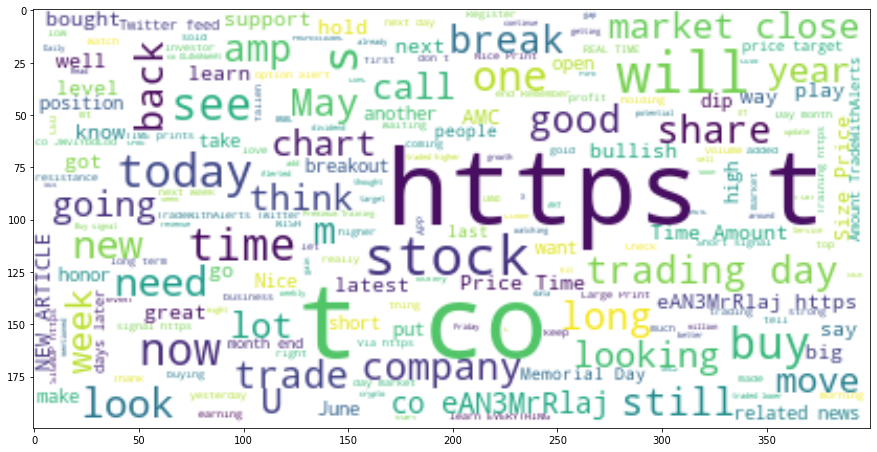

In [18]:
df = filtered_df

show_wordcloud(df)

The most prominent phrases from the word clouds are rather finance related. This seems good for our analysis.
<br>
However, there are still some unrelated words in there, like those from links which many tweets contain. Let us do some basic cleaning on the text and see the difference
* Remove links completely
* Remove account handles from tweets, in the form of @username
* Remove & sign which turns out as '\&amp;' in the text
* Turn all text to lower case

In [19]:
def basic_clean(text):
    text = re.sub('(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)', '', text) # Remove links
    text = re.sub('@(\w+)', '', text) # Remove account handles
    text = re.sub('&amp;', '', text) # Remove ampersand from text
    text = text.lower()
    return " ".join(text.split())

example = """As @WaltLightShed points out, AT&amp;T now promising to roll out 
             its 5G C-band network to 200 million by the end of 2023"""

basic_clean(example)

'as points out, att now promising to roll out its 5g c-band network to 200 million by the end of 2023'

In [20]:
df.tweet = df.tweet.apply(basic_clean)

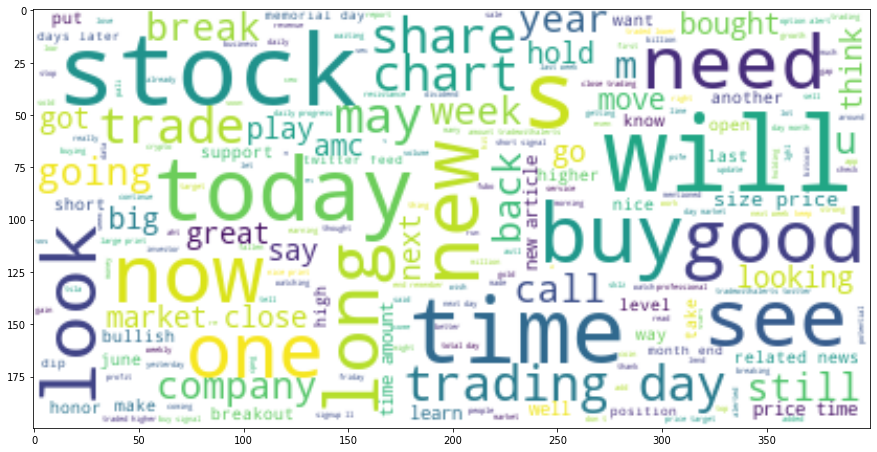

In [21]:
show_wordcloud(df)

Now the wordclouds look good enough for the training of a NLP model. Words like 'long', 'buy' and 'good' can signify a bullish sentiment from investors, while words like 'hold' could signify a bearish sentiment
<br>
Let us save this filtered tweets dataset and use it to train a NLP model.

In [22]:
import csv
df.to_csv('filtered_tweets.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)